---
title: GSB - S544 Lab 6
author: Karissa Mohr
format:
  html:
    embed-resources: true
echo: true
theme: lux
---

# Lab 6: Variable Selection and Regularization

## Data Prep

In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Hitters.csv to Hitters.csv


In [ ]:
baseball = pd.read_csv('Hitters.csv')
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
baseball = baseball.dropna(subset=["Salary"])
baseball = baseball.dropna()

In [ ]:
X = baseball.drop("Salary", axis=1)
y = baseball["Salary"]

In [ ]:
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

## Part I: Different Model Specs


### A. Regression without regularization
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [20]:
# ols pipeline
ols_pipe = Pipeline([
    ("preprocessing", ct),
    ("ols", LinearRegression())
])

ols_pipe.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ddf7130f9e0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ddf7bdcbe90>)])),
                ('ols', LinearRegression())])

In [21]:
ols_pipe.named_steps['ols'].coef_

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [22]:
# coefficients
ols_coefs = ols_pipe.named_steps['ols'].coef_
column_names = ols_pipe.named_steps['preprocessing'].get_feature_names_out()
coef_df = pd.DataFrame({"Stat": column_names, "Coefficient": ols_coefs})
coef_df.sort_values("Coefficient", ascending=False).head(10)

,Stat,Coefficient
16,standardize__CRuns,480.747135
7,standardize__Hits,337.830479
17,standardize__CRBI,260.689886
11,standardize__Walks,135.073897
14,standardize__CHits,86.687617
19,standardize__PutOuts,78.761296
2,dummify__Division_E,58.424623
20,standardize__Assists,53.732490
8,standardize__HmRun,37.853837
1,dummify__League_N,31.299712


Players with higher career runs, hits, and RBIs tend to earn higher salaries (because they have the largest coefficients) and each coefficient is the effect of a one standard deviation increase in performance on salary.

In [ ]:
# MSE
ols_scores = cross_val_score(ols_pipe, X, y, cv=5, scoring='neg_mean_squared_error')
ols_mse = -ols_scores.mean()
ols_mse

np.float64(121136.31031816888)

### B. Ridge regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the λ hyperparameter.

3. Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [24]:
# ridge pipeline
from sklearn.linear_model import Ridge

ridge_pipe = Pipeline([
    ("preprocessing", ct),
    ("ridge", Ridge())
])

In [25]:
# tune hyperparameter
ridge_grid = {"ridge__alpha": np.logspace(-4, 4, 25)}

ridge_search = GridSearchCV(ridge_pipe,ridge_grid,cv=5,scoring='neg_mean_squared_error')

ridge_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ddf7130f9e0>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_...
       2.15443469e-03, 4.64158883e-03, 1.00000000e-02, 2.15443469e-02,
       4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01,
       1.00000000e+00, 2.15443469e+00, 4.64158883e+00, 1.00000000e+01,
       2.15443469e+01, 4.64158883e+01, 1.00000000e+02, 2.15443469e+02,
       4.64158883e+02, 1.00000000e+03, 2.15443469e+03, 4.64158883e+03,
       1.00000000e+04])},
             scoring='neg_mean_squared_error')

In [28]:
# coefficients
ridge_best_alpha = ridge_search.best_params_["ridge__alpha"]

ridge_best = ridge_search.best_estimator_

ridge_coefs = ridge_best.named_steps["ridge"].coef_

print("Best λ:", ridge_best_alpha)
ridge_coefs

Best λ: 2.154434690031882


array([ -29.43656289,   29.43656289,   60.68754795,  -60.68754795,
         12.6741759 ,  -12.6741759 , -243.63976409,  261.83979705,
          8.1174739 ,  -11.90643435,   -0.46038971,  115.11947325,
        -47.69155513, -142.79715425,  125.41126567,   53.23624871,
        246.24379694,  129.39185412, -163.50496086,   78.17366537,
         42.91618944,  -24.54160386])

In [30]:
column_names = ridge_best.named_steps['preprocessing'].get_feature_names_out()
coef_df = pd.DataFrame({"Stat": column_names,"Coefficient": ridge_coefs})

coef_df.sort_values("Coefficient", ascending=False).head(10)

,Stat,Coefficient
7,standardize__Hits,261.839797
16,standardize__CRuns,246.243797
17,standardize__CRBI,129.391854
14,standardize__CHits,125.411266
11,standardize__Walks,115.119473
19,standardize__PutOuts,78.173665
2,dummify__Division_E,60.687548
15,standardize__CHmRun,53.236249
20,standardize__Assists,42.916189
1,dummify__League_N,29.436563


Ridge penalty is about 2.15. The coefficients for each baseball statisitic are much lower in the ridge model, but still the top 3 stats that effect salary are hits, runs and RBI.

In [33]:
# MSE
ridge_mse = -ridge_search.best_score_
ridge_mse

np.float64(118958.4190450334)

### C. Lasso Regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the λ hyperparameter.

3. Fit the pipeline with your chosen λ to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [31]:
# lasso pipeline
from sklearn.linear_model import Lasso

lasso_pipe = Pipeline([
    ("preprocessing", ct),
    ("lasso", Lasso(max_iter=10000))
])

In [34]:
# tune hyperparameter
lasso_grid = {"lasso__alpha": np.logspace(-4, 1, 25)}

lasso_search = GridSearchCV(lasso_pipe,lasso_grid,cv=5,scoring='neg_mean_squared_error')

lasso_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ddf7130f9e0>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_...
       6.81292069e-04, 1.10069417e-03, 1.77827941e-03, 2.87298483e-03,
       4.64158883e-03, 7.49894209e-03, 1.21152766e-02, 1.95734178e-02,
       3.16227766e-02, 5.10896977e-02, 8.25404185e-02, 1.33352143e-01,
       2.15443469e-01, 3.48070059e-01, 5.62341325e-01, 9.08517576e-01,
       1.46779927e+00, 2.37137371e+00, 3.83118685e+00, 6.18965819e+00,
       1.00000000e+01])},
             scoring='neg_mean_squared_error')

In [35]:
# coefficients
lasso_best_alpha = lasso_search.best_params_["lasso__alpha"]

lasso_best = lasso_search.best_estimator_

lasso_coefs = lasso_best.named_steps["lasso"].coef_

column_names = lasso_best.named_steps["preprocessing"].get_feature_names_out()

lasso_coef_df = pd.DataFrame({
    "Stat": column_names,
    "Coefficient": lasso_coefs
})

print("Best λ:", lasso_best_alpha)
lasso_coef_df.sort_values("Coefficient", ascending=False).head(10)


Best λ: 2.371373705661655


,Stat,Coefficient
7,standardize__Hits,265.750716
16,standardize__CRuns,228.985336
17,standardize__CRBI,123.393716
2,dummify__Division_E,114.429118
11,standardize__Walks,106.432687
19,standardize__PutOuts,77.113379
15,standardize__CHmRun,45.736358
20,standardize__Assists,27.621365
8,standardize__HmRun,0.000000
5,dummify__NewLeague_N,0.000000


The lasso penalty is 2.37 (higher than ridge), and the top 3 stats that contribute to salary ate still hits, runs and RBI.The coefficients are slightly different.

In [36]:
# MSE
lasso_mse = -lasso_search.best_score_
lasso_mse

np.float64(119078.25862376203)

Higher MSE than Ridge, lower MSE than OLS.

### D. Elastic Net
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the λ and α hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.



In [37]:
# elastic pipeline
from sklearn.linear_model import ElasticNet

elastic_pipe = Pipeline([
    ("preprocessing", ct),
    ("elastic_pipe", ElasticNet(max_iter=10000))
])

In [43]:
# tune hyperparameters
elastic_grid = {
    "elastic_pipe__alpha": np.logspace(-4, 1, 15),
    "elastic_pipe__l1_ratio": np.linspace(0.1, 0.9, 9)
}

elastic_search = GridSearchCV(elastic_pipe,elastic_grid,cv=5,scoring='neg_mean_squared_error')

elastic_search.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.165e+03, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.611e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.463e+05, tolerance: 4.558e

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ddf7130f9e0>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_...
             param_grid={'elastic_pipe__alpha': array([1.00000000e-04, 2.27584593e-04, 5.17947468e-04, 1.17876863e-03,
       2.68269580e-03, 6.10540230e-03, 1.38949549e-02, 3.16227766e-02,
       7.19685673e-02, 1.63789371e-01, 3.72759372e-01, 8.48342898e-01,
       1.93069773e+00, 4.39397056e+00, 1.00000000e+01]),
                         'elastic_pipe__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='neg_mean_squared_error')

In [44]:
# coefficients
elastic_best_alpha = elastic_search.best_params_["elastic_pipe__alpha"]
elastic_best_l1    = elastic_search.best_params_["elastic_pipe__l1_ratio"]
elastic_best       = elastic_search.best_estimator_

elastic_coefs = elastic_best.named_steps["elastic_pipe"].coef_

column_names = elastic_best.named_steps["preprocessing"].get_feature_names_out()

elastic_coef_df = pd.DataFrame({
    "Stat": column_names,
    "Coefficient": elastic_coefs
}).sort_values("Coefficient", ascending=False)

print("Best λ:", elastic_best_alpha)
print("Best α:", elastic_best_l1)
elastic_coef_df.head(10)


Best λ: 0.013894954943731374
Best α: 0.1


,Stat,Coefficient
7,standardize__Hits,235.262065
16,standardize__CRuns,205.628495
14,standardize__CHits,120.900797
17,standardize__CRBI,116.526261
11,standardize__Walks,107.783977
19,standardize__PutOuts,77.704103
2,dummify__Division_E,60.899221
15,standardize__CHmRun,57.632666
20,standardize__Assists,39.668641
1,dummify__League_N,28.533439


The top 3 predictors of salary are hits, runs and career hits in this model, not RBI! The lambda is about 0.014 and the alpha is 0.1.

In [45]:
# MSE
elastic_mse = -elastic_search.best_score_
elastic_mse

np.float64(118939.16881986277)

In [46]:
# Compare Models

print("OLS:", ols_mse)
print("Ridge:", ridge_mse)
print("Lasso:", lasso_mse)
print("Elastic Net:", elastic_mse)

OLS: 121136.31031816888
Ridge: 118958.4190450334
Lasso: 119078.25862376203
Elastic Net: 118939.16881986277


Elastic Net has the lowest MSE, meaning it is the best model of fit and accounts for regularization better than Ridge and Lasso.

## Part II. Variable Selection
Based on the above results, decide on:

* Which numeric variable is most important.

* Which five numeric variables are most important

* Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note:
 λ and α
 must be re-tuned for each feature set.)

In [47]:
# most important numeric coef
coefs = elastic_coef_df.copy()
coefs["abs_coef"] = coefs["Coefficient"].abs()
coefs_sorted = coefs.sort_values("abs_coef", ascending=False)
coefs_sorted.head(10)

,Stat,Coefficient,abs_coef
7,standardize__Hits,235.262065,235.262065
6,standardize__AtBat,-219.946641,219.946641
16,standardize__CRuns,205.628495,205.628495
18,standardize__CWalks,-147.802478,147.802478
14,standardize__CHits,120.900797,120.900797
17,standardize__CRBI,116.526261,116.526261
11,standardize__Walks,107.783977,107.783977
13,standardize__CAtBat,-100.166632,100.166632
19,standardize__PutOuts,77.704103,77.704103
3,dummify__Division_W,-60.899233,60.899233


The five most important numeric variables are Hits, AtBat, CRuns, CWalks, and CHits.

In [48]:
# categorical coef
coefs = elastic_coef_df.copy()
coefs["abs_coef"] = coefs["Coefficient"].abs()

cat_coefs = coefs[coefs["Stat"].str.contains("dummify__")].copy()

cat_coefs["Category"] = cat_coefs["Stat"].str.extract(r'dummify__(\w+)_')

cat_importance = cat_coefs.groupby("Category")["abs_coef"].sum().sort_values(ascending=False)
cat_importance


,abs_coef
Category,
Division,121.798453
League,57.066881
NewLeague,23.900351


The most influential categorical variable is division.

In [49]:
# sets
best_num = "Hits"
best_five = ["Hits", "AtBat", "CRuns", "CWalks", "CHits"]
best_cat = "Division"

In [ ]:
# column transformers


# one numeric variable
ct_1 = ColumnTransformer([
    ("standardize", StandardScaler(), [best_num])
])

# five numeric variables
ct_2 = ColumnTransformer([
    ("standardize", StandardScaler(), best_five)
])

# five numeric variables + best categorical variable
ct_3 = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [best_cat]),
    ("standardize", StandardScaler(), best_five)
])

In [74]:
# ols for numeric variable
ols_1num = Pipeline([
    ("preprocessing", ct_1),
    ("ols", LinearRegression())
])

ols_1num_mse = -cross_val_score(ols_1num, X, y, cv=5, scoring='neg_mean_squared_error').mean()
ols_1num_mse

np.float64(173088.97286444032)

In [ ]:
# ridge for numeric variable
ridge_grid = {"ridge__alpha": np.logspace(-4, 4, 25)}

ridge_1num = Pipeline([
    ("preprocessing", ct_1),
    ("ridge", Ridge())
])

ridge_1num_search = GridSearchCV(ridge_1num, ridge_grid, cv=5, scoring='neg_mean_squared_error')
ridge_1num_search.fit(X, y)

print("Ridge (1 numeric) Best λ:", ridge_1num_search.best_params_["ridge__alpha"])
print("Ridge (1 numeric) CV MSE:", -ridge_1num_search.best_score_)

Ridge (1 numeric) Best λ: 21.54434690031882
Ridge (1 numeric) CV MSE: 172591.50663397383


In [55]:
# lasso for numeric variable
lasso_grid = {"lasso__alpha": np.logspace(-4, 1, 25)}

lasso_1num = Pipeline([
    ("preprocessing", ct_1),
    ("lasso", Lasso(max_iter=10000))
])

lasso_1num_search = GridSearchCV(lasso_1num, lasso_grid, cv=5, scoring='neg_mean_squared_error')
lasso_1num_search.fit(X, y)

print("LASSO (1 numeric) Best λ:", lasso_1num_search.best_params_["lasso__alpha"])
print("LASSO (1 numeric) CV MSE:", -lasso_1num_search.best_score_)

LASSO (1 numeric) Best λ: 6.18965818891261
LASSO (1 numeric) CV MSE: 173047.6681062308


In [58]:
# elastic net for numeric variable
elastic_grid = {
    "elastic__alpha": np.logspace(-4, 1, 10),
    "elastic__l1_ratio": np.linspace(0.1, 0.9, 9)
}

elastic_1num = Pipeline([
    ("preprocessing", ct_1),
    ("elastic", ElasticNet(max_iter=10000))
])

elastic_1num_search = GridSearchCV(elastic_1num, elastic_grid, cv=5, scoring='neg_mean_squared_error')
elastic_1num_search.fit(X, y)

print("Elastic Net (1 numeric) Best λ:", elastic_1num_search.best_params_["elastic__alpha"])
print("Elastic Net (1 numeric) Best α:", elastic_1num_search.best_params_["elastic__l1_ratio"])
print("Elastic Net (1 numeric) CV MSE:", -elastic_1num_search.best_score_)


Elastic Net (1 numeric) Best λ: 0.21544346900318845
Elastic Net (1 numeric) Best α: 0.4
Elastic Net (1 numeric) CV MSE: 172571.362999603


In [59]:
# ols for 5 numeric
ols_5num = Pipeline([
    ("preprocessing", ct_2),
    ("ols", LinearRegression())
])
ols_5num_mse = -cross_val_score(ols_5num, X, y, cv=5, scoring='neg_mean_squared_error').mean()
ols_5num_mse


np.float64(127818.20009326501)

In [60]:
# ridge for 5 numeric
ridge_5num = Pipeline([
    ("preprocessing", ct_2),
    ("ridge", Ridge())
])
ridge_5num_search = GridSearchCV(ridge_5num, ridge_grid, cv=5, scoring='neg_mean_squared_error')
ridge_5num_search.fit(X, y)
print("Ridge (5 numeric) Best λ:", ridge_5num_search.best_params_["ridge__alpha"])
print("Ridge (5 numeric) CV MSE:", -ridge_5num_search.best_score_)


Ridge (5 numeric) Best λ: 2.154434690031882
Ridge (5 numeric) CV MSE: 127248.34853682511


In [61]:
# lasso for 5 numeric
lasso_5num = Pipeline([
    ("preprocessing", ct_2),
    ("lasso", Lasso(max_iter=10000))
])
lasso_5num_search = GridSearchCV(lasso_5num, lasso_grid, cv=5, scoring='neg_mean_squared_error')
lasso_5num_search.fit(X, y)
print("LASSO (5 numeric) Best λ:", lasso_5num_search.best_params_["lasso__alpha"])
print("LASSO (5 numeric) CV MSE:", -lasso_5num_search.best_score_)


LASSO (5 numeric) Best λ: 2.371373705661655
LASSO (5 numeric) CV MSE: 126883.45601598448


In [63]:
# elastic net for 5 numeric
elastic_5num = Pipeline([
    ("preprocessing", ct_2),
    ("elastic", ElasticNet(max_iter=10000))
])
elastic_5num_search = GridSearchCV(elastic_5num, elastic_grid, cv=5, scoring='neg_mean_squared_error')
elastic_5num_search.fit(X, y)
print("Elastic Net (5 numeric) Best λ:", elastic_5num_search.best_params_["elastic__alpha"])
print("Elastic Net (5 numeric) Best α:", elastic_5num_search.best_params_["elastic__l1_ratio"])
print("Elastic Net (5 numeric) CV MSE:", -elastic_5num_search.best_score_)


Elastic Net (5 numeric) Best λ: 0.05994842503189409
Elastic Net (5 numeric) Best α: 0.9
Elastic Net (5 numeric) CV MSE: 127219.51712152555


In [64]:
# ols for numeric + categorical
ols_5num_cat = Pipeline([
    ("preprocessing", ct_3),
    ("ols", LinearRegression())
])
ols_5num_cat_mse = -cross_val_score(ols_5num_cat, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print("OLS (5 numeric + cat) CV MSE:", ols_5num_cat_mse)

OLS (5 numeric + cat) CV MSE: 125062.83404326325


In [65]:
# ridge for numeric + categorical
ridge_5num_cat = Pipeline([
    ("preprocessing", ct_3),
    ("ridge", Ridge())
])
ridge_5num_cat_search = GridSearchCV(ridge_5num_cat, ridge_grid, cv=5, scoring='neg_mean_squared_error')
ridge_5num_cat_search.fit(X, y)
print("Ridge (5 numeric + cat) Best λ:", ridge_5num_cat_search.best_params_["ridge__alpha"])
print("Ridge (5 numeric + cat) CV MSE:", -ridge_5num_cat_search.best_score_)

Ridge (5 numeric + cat) Best λ: 2.154434690031882
Ridge (5 numeric + cat) CV MSE: 124456.32808586357


In [68]:
# lasso for numeric + cat
lasso_5num_cat = Pipeline([
    ("preprocessing", ct_3),
    ("lasso", Lasso(max_iter=10000))
])
lasso_5num_cat_search = GridSearchCV(lasso_5num_cat, lasso_grid, cv=5, scoring='neg_mean_squared_error')
lasso_5num_cat_search.fit(X, y)
print("LASSO (5 numeric + cat) Best λ:", lasso_5num_cat_search.best_params_["lasso__alpha"])
print("LASSO (5 numeric + cat) CV MSE:", -lasso_5num_cat_search.best_score_)


LASSO (5 numeric + cat) Best λ: 1.4677992676220706
LASSO (5 numeric + cat) CV MSE: 124022.76311089608


In [67]:
# elastic net for numeric + cat
elastic_5num_cat = Pipeline([
    ("preprocessing", ct_3),
    ("elastic", ElasticNet(max_iter=10000))
])
elastic_5num_cat_search = GridSearchCV(elastic_5num_cat, elastic_grid, cv=5, scoring='neg_mean_squared_error')
elastic_5num_cat_search.fit(X, y)
print("Elastic Net (5 numeric + cat) Best λ:", elastic_5num_cat_search.best_params_["elastic__alpha"])
print("Elastic Net (5 numeric + cat) Best α:", elastic_5num_cat_search.best_params_["elastic__l1_ratio"])
print("Elastic Net (5 numeric + cat) CV MSE:", -elastic_5num_cat_search.best_score_)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.845e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e+05, tolerance: 4.558e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.374e+06, tolerance: 4.708e

Elastic Net (5 numeric + cat) Best λ: 0.016681005372000592
Elastic Net (5 numeric + cat) Best α: 0.4
Elastic Net (5 numeric + cat) CV MSE: 124453.35508389906


## Part III. Discussion

### A. Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?



Compared to the OLS Models, the Ridge coefficients are consistently smaller than the OLS coefficients but have the same general direction (negative/positive). This happens because Ridge adds a penalty that shrinks large coefficients toward zero, reducing the influence of any one variable. The result is a more stable model with less overfitting and a lower cross validated MSE.

### B. LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same
 λ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?



The LASSO models in Part II gave different λ values and MSEs than the one in Part I. This makes sense because each model used different sets of predictors, so the penalty had to change to find the best fit. The MSEs were also different since LASSO’s performance depends on which variables are included, thus how strongly it shrinks the coefficients.

### C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?



The Elastic Net models had lower MSEs than both Ridge and LASSO. This makes sense because Elastic Net combines the strengths of both methods by keeping Ridge’s stability with correlated predictors and LASSO’s ability to set unimportant coefficients to zero. By balancing these two penalties, it usually gives the best mix of bias and variance, which is why it usially ends up being the best model everytime.

## Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [ ]:
# Compare all models
mse_list = [
    ("OLS (1 num)", ols_1num_mse),
    ("Ridge (1 num)", -ridge_1num_search.best_score_),
    ("LASSO (1 num)", -lasso_1num_search.best_score_),
    ("Elastic Net (1 num)", -elastic_1num_search.best_score_),

    ("OLS (5 num)", ols_5num_mse),
    ("Ridge (5 num)", -ridge_5num_search.best_score_),
    ("LASSO (5 num)", -lasso_5num_search.best_score_),
    ("Elastic Net (5 num)", -elastic_5num_search.best_score_),

    ("OLS (5 num + cat)", ols_5num_cat_mse),
    ("Ridge (5 num + cat)", -ridge_5num_cat_search.best_score_),
    ("LASSO (5 num + cat)", -lasso_5num_cat_search.best_score_),
    ("Elastic Net (5 num + cat)", -elastic_5num_cat_search.best_score_)
]

comparison = pd.DataFrame(mse_list, columns=["Model", "MSE"])
comparison = comparison.sort_values("MSE").reset_index(drop=True)

comparison

,Model,MSE
0,LASSO (5 num + cat),124022.763111
1,Elastic Net (5 num + cat),124453.355084
2,Ridge (5 num + cat),124456.328086
3,OLS (5 num + cat),125062.834043
4,LASSO (5 num),126883.456016
5,Elastic Net (5 num),127219.517122
6,Ridge (5 num),127248.348537
7,OLS (5 num),127818.200093
8,Elastic Net (1 num),172571.363000
9,Ridge (1 num),172591.506634


In [84]:
# Best Model: Lasso with 5 numerical and 1 categorical
final_model = lasso_5num_cat_search.best_estimator_
final_model.fit(X, y)

final_coefs = pd.DataFrame({
    "Stat": final_model.named_steps["preprocessing"].get_feature_names_out(),
    "Coefficient": final_model.named_steps["lasso"].coef_
}).sort_values("Coefficient", ascending=False)

final_coefs

,Stat,Coefficient
2,standardize__Hits,2.736859e+02
4,standardize__CRuns,2.168220e+02
0,dummify__Division_E,1.173391e+02
6,standardize__CHits,-0.000000e+00
5,standardize__CWalks,0.000000e+00
1,dummify__Division_W,-1.985699e-12
3,standardize__AtBat,-1.393593e+02


The LASSO model using the five numeric variables and one categorical had the lowest cross-validated MSE. The largest positive coefficients were for Hits and CRuns, showing that strong performance in those categories lead to higher salaries. The negative coefficients (like AtBat and CHits) show how LASSO removes/shrinks less useful predictors, giving a simpler model and helps to work against overfitting.

In [81]:
from plotnine import *

In [85]:
coefs = final_coefs.copy()

coefs["Stat"] = (
    coefs["Stat"]
    .str.replace("standardize__", "", regex=False)
    .str.replace("dummify__", "", regex=False)
)

In [92]:
# getting rid of really small coefficients (the ones that are penalized) so the bars dont look blank on plot
coefs = coefs[coefs["Coefficient"].abs() > 1e-6]

In [90]:
# sort
coefs = coefs.sort_values("Coefficient", ascending=False)

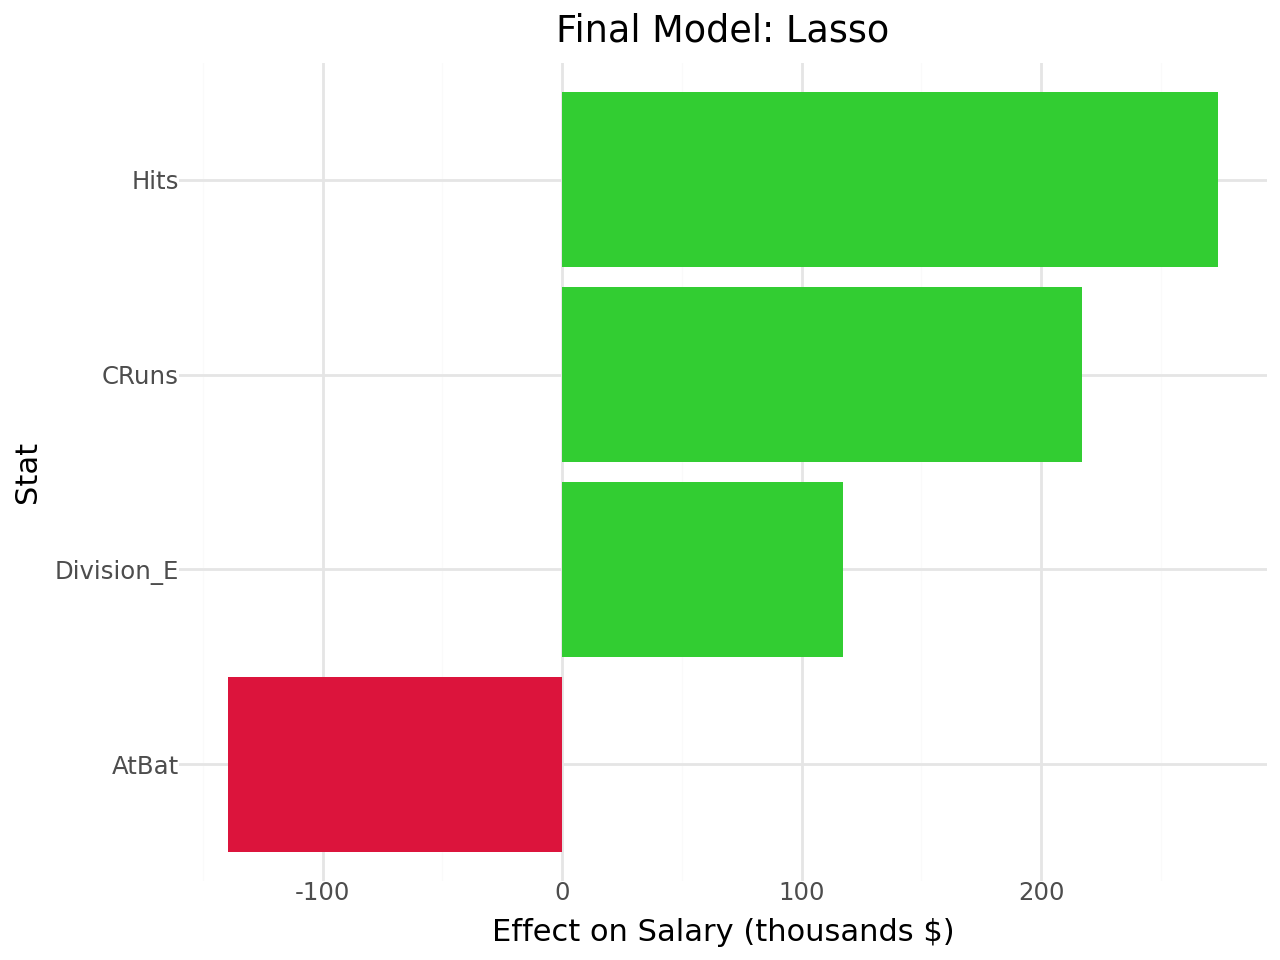

In [89]:
(ggplot(coefs, aes(x="reorder(Stat, Coefficient)", y="Coefficient", fill="Coefficient > 0"))
    + geom_col(show_legend=False)
    + coord_flip()
    + scale_fill_manual(
        values=["crimson", "limegreen"])
    + labs(
        title="Final Model: Lasso",
        x="Stat",
        y="Effect on Salary (thousands $)"
    )
    + theme_minimal()
)